<a href="https://colab.research.google.com/github/jrbobes/jrbobes-hitl-ml/blob/master/HITL_XAI_Pancreas_DT_medium.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **HTIL_Pancreas_XAI_DT_Medium**

author: jose.bobes at udc.es

Decission tree with a medium set of parameters.

# Importing required libraries

In [1]:
# Importing Required Libraries
import sys
print('Python: {}'.format(sys.version))

import scipy
print('scipy: {}'.format(scipy.__version__))

import numpy as np
print('numpy: {}'.format(np.__version__))

import re
print('re: {}'.format(re.__version__))

import graphviz
print('graphviz: {}'.format(graphviz.__version__))

import matplotlib
import matplotlib.pyplot as plt
print('matplotlib: {}'.format(matplotlib.__version__))

import pandas as pd
print('pandas: {}'.format(pd.__version__))

import sklearn
print('sklearn: {}'.format(sklearn.__version__))

from sklearn import metrics
from sklearn import tree

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

Python: 3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]
scipy: 1.11.3
numpy: 1.23.5
re: 2.2.1
graphviz: 0.20.1
matplotlib: 3.7.1
pandas: 1.5.3
sklearn: 1.2.2


# Cleaning the Pancreas dataset

In [2]:
# 1. Set the FEATURE_NAMES to be used to train the model, except for the therapy_type which is the target.
features = ['ajcc_pathologic_stage',
            'ajcc_pathologic_t',
            'ajcc_pathologic_m',
            'ajcc_pathologic_n',
            'primary_diagnosis',
            'tissue_or_organ_of_origin',
            'age_at_index',
            'therapy_type',
            'prior_malignancy',
            'prior_treatment',
            'gender',
            'race',
            'ethnicity',
            'treatment_type']


In [3]:
# 2. Load the dataset
url = "https://raw.githubusercontent.com/jrbobes/jrbobes-hitl-ml/master/tcga-paad-inicial.csv"

dataset = pd.read_csv(url, sep=';', usecols=features, encoding = "ISO-8859-1")
dataset = dataset.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

print(dataset.shape)
print(dataset.head())

(185, 14)
   therapy_type               treatment_type  age_at_index  \
0         Other  Pharmaceutical Therapy, NOS            53   
1         Other  Pharmaceutical Therapy, NOS            54   
2         Other  Pharmaceutical Therapy, NOS            58   
3  Chemotherapy  Pharmaceutical Therapy, NOS            66   
4         Other       Radiation Therapy, NOS            64   

                ethnicity  gender                       race  \
0  not hispanic or latino  female                      white   
1  not hispanic or latino  female                      white   
2  not hispanic or latino  female                      white   
3  not hispanic or latino  female  black or african american   
4  not hispanic or latino    male                      white   

  ajcc_pathologic_m ajcc_pathologic_n ajcc_pathologic_stage ajcc_pathologic_t  \
0                M0                N1             Stage IIB                T3   
1                MX                N0             Stage IIA           

In [4]:
# 3. Show Datatypes
for column, dtype in zip(dataset.columns, dataset.dtypes):
    print(f"{column}:{dtype}")

therapy_type:object
treatment_type:object
age_at_index:int64
ethnicity:object
gender:object
race:object
ajcc_pathologic_m:object
ajcc_pathologic_n:object
ajcc_pathologic_stage:object
ajcc_pathologic_t:object
primary_diagnosis:object
prior_malignancy:object
prior_treatment:object
tissue_or_organ_of_origin:object


In [5]:
# 4. Missing Values/ Null Values
dataset_null = dataset.isnull()
print(dataset.isnull().sum())

therapy_type                 0
treatment_type               0
age_at_index                 0
ethnicity                    0
gender                       0
race                         0
ajcc_pathologic_m            0
ajcc_pathologic_n            1
ajcc_pathologic_stage        3
ajcc_pathologic_t            1
primary_diagnosis            0
prior_malignancy             0
prior_treatment              0
tissue_or_organ_of_origin    0
dtype: int64


In [6]:
# 5. Fill in the missing values
#dataset.days_to_death = dataset.days_to_death.fillna(18250) # Asignamos un valor muy alto (50 años)
dataset.ajcc_pathologic_stage = dataset.ajcc_pathologic_stage.fillna('Stage 0')
dataset.ajcc_pathologic_t = dataset.ajcc_pathologic_t.fillna('TX')
dataset.ajcc_pathologic_m = dataset.ajcc_pathologic_m.fillna('MX')
dataset.ajcc_pathologic_n = dataset.ajcc_pathologic_n.fillna('NX')

dataset_null = dataset.isnull()
print(dataset.isnull().sum())

therapy_type                 0
treatment_type               0
age_at_index                 0
ethnicity                    0
gender                       0
race                         0
ajcc_pathologic_m            0
ajcc_pathologic_n            0
ajcc_pathologic_stage        0
ajcc_pathologic_t            0
primary_diagnosis            0
prior_malignancy             0
prior_treatment              0
tissue_or_organ_of_origin    0
dtype: int64


In [7]:
# 6. Removing Redundancy
count_duplicates = dataset[dataset.duplicated()].shape[0]
print("Number of duplicate rows:", count_duplicates)

Number of duplicate rows: 6


In [8]:
# There are 6 duplicates with the columns selected.
dataset[dataset.duplicated()]

therapy_type               treatment_type  age_at_index  \
91          Other  Pharmaceutical Therapy, NOS            65   
117  Chemotherapy       Radiation Therapy, NOS            56   
142  Chemotherapy       Radiation Therapy, NOS            69   
147  Chemotherapy       Radiation Therapy, NOS            71   
152  Chemotherapy       Radiation Therapy, NOS            71   
171  Chemotherapy  Pharmaceutical Therapy, NOS            65   

                  ethnicity  gender   race ajcc_pathologic_m  \
91   not hispanic or latino  female  white                MX   
117            not reported    male  white                M0   
142  not hispanic or latino  female  white                MX   
147            not reported    male  white                M0   
152            not reported    male  white                M0   
171  not hispanic or latino    male  white                MX   

    ajcc_pathologic_n ajcc_pathologic_stage ajcc_pathologic_t  \
91                 N1             Stage IIB                T3   
117                N1             Stage IIB                T3   
142                N1             Stage IIB                T3   
147                N1             Stage IIB                T3   
152                N1             Stage IIB                T3   
171                N1             Stage IIB                T3   

                    primary_diagnosis prior_malignancy prior_treatment  \
91   Infiltrating duct carcinoma, NOS               no              No   
117  Infiltrating duct carcinoma, NOS               no              No   
142  Infiltrating duct carcinoma, NOS               no              No   
147  Infiltrating duct carcinoma, NOS               no              No   
152  Infiltrating duct carcinoma, NOS               no              No   
171  Infiltrating duct carcinoma, NOS               no              No   

    tissue_or_organ_of_origin  
91           Head of pancreas  
117          Head of pancreas  
142          Head of pancreas  
147          Head of pancreas  
152          Head of pancreas  
171          Head of pancreas

# Data Preparation

In [9]:
# 1. Simplify Target with only Chemotherapy or Other
dataset['therapy_type'] = dataset['therapy_type'].replace('Hormone Therapy', 'Other')
dataset['therapy_type'] = dataset['therapy_type'].replace('Vaccine', 'Other')
dataset['therapy_type'] = dataset['therapy_type'].replace('Ancillary', 'Other')

# check that we only get two values: 'Chemotherapy' and 'Other'
dataset['therapy_type'].unique()

array(['Other', 'Chemotherapy'], dtype=object)

In [10]:
# 2. Convert categorical variables into numerical.
# Categorical features need to be transformed before they can be used in a model.

dataset['ajcc_pathologic_stage'] = dataset['ajcc_pathologic_stage'].replace('Stage 0', 0)
dataset['ajcc_pathologic_stage'] = dataset['ajcc_pathologic_stage'].replace('Stage I', 1)
dataset['ajcc_pathologic_stage'] = dataset['ajcc_pathologic_stage'].replace('Stage IA', 2)
dataset['ajcc_pathologic_stage'] = dataset['ajcc_pathologic_stage'].replace('Stage IB', 3)
dataset['ajcc_pathologic_stage'] = dataset['ajcc_pathologic_stage'].replace('Stage II', 4)
dataset['ajcc_pathologic_stage'] = dataset['ajcc_pathologic_stage'].replace('Stage IIA', 5)
dataset['ajcc_pathologic_stage'] = dataset['ajcc_pathologic_stage'].replace('Stage IIB', 6)
dataset['ajcc_pathologic_stage'] = dataset['ajcc_pathologic_stage'].replace('Stage III', 7)
dataset['ajcc_pathologic_stage'] = dataset['ajcc_pathologic_stage'].replace('Stage IV', 8)

dataset['ajcc_pathologic_t'] = dataset['ajcc_pathologic_t'].replace('TX', 0)
dataset['ajcc_pathologic_t'] = dataset['ajcc_pathologic_t'].replace('T1', 1)
dataset['ajcc_pathologic_t'] = dataset['ajcc_pathologic_t'].replace('T2', 2)
dataset['ajcc_pathologic_t'] = dataset['ajcc_pathologic_t'].replace('T3', 3)
dataset['ajcc_pathologic_t'] = dataset['ajcc_pathologic_t'].replace('T4', 4)

dataset['ajcc_pathologic_n'] = dataset['ajcc_pathologic_n'].replace('N0', 0)
dataset['ajcc_pathologic_n'] = dataset['ajcc_pathologic_n'].replace('N1', 1)
dataset['ajcc_pathologic_n'] = dataset['ajcc_pathologic_n'].replace('N1b', 2)
dataset['ajcc_pathologic_n'] = dataset['ajcc_pathologic_n'].replace('NX', 3)

dataset['ajcc_pathologic_m'] = dataset['ajcc_pathologic_m'].replace('M0', 0)
dataset['ajcc_pathologic_m'] = dataset['ajcc_pathologic_m'].replace('M1', 1)
dataset['ajcc_pathologic_m'] = dataset['ajcc_pathologic_m'].replace('MX', 2)

In [11]:
# 3. Drop unneeded Features
# Remove therapy_type from the X vector, and keep it as the target.
X = dataset.drop(['therapy_type'], axis=1)
y = dataset['therapy_type']

In [12]:
# 4. Use One-hot encoding for the rest of categorical features. We get a binary variable for each category.
X_encoded = pd.get_dummies(X)

In [13]:
# 5. Split the data in train and test sets
X_train,X_test,y_train,y_test = train_test_split(X_encoded, y, test_size=0.3,random_state=42)

# Creating a Decision Tree model

In [48]:
# 1. Get the best possible parameters for a Decision Tree
best_acc = 0

for criterion in "gini", "entropy":
    for max_depth in [2,3,4,5,6]:
        for min_samples_leaf in [5, 10, 20, 30]:
            dtree = tree.DecisionTreeClassifier(max_depth=max_depth, criterion=criterion, min_samples_leaf=min_samples_leaf)
            dtree.fit(X_train, y_train)
            predicitions = dtree.predict(X_test)
            acc = metrics.accuracy_score(y_test, predicitions)
            if acc > best_acc:
                best_params = f"criterion: {criterion}, max_depth: {max_depth}, min_samples_leaf: {min_samples_leaf}"
                best_acc = acc

print("Decision Tree Best Parameters: ", best_params)
print("Decision Tree Best Accuracy: ", best_acc)

Decision Tree Best Parameters:  criterion: gini, max_depth: 2, min_samples_leaf: 20
Decision Tree Best Accuracy:  0.6785714285714286


In [49]:
# 2. Create the Decision Tree model and fit the training data
dt_clf = tree.DecisionTreeClassifier(random_state=42, max_depth=2, min_samples_leaf=20)
dt_clf = dt_clf.fit(X_train, y_train)

In [50]:
# 3. Predict over the test data and show accuracy
y_dt_pred = dt_clf.predict(X_test)
dt_acc = metrics.accuracy_score(y_test, y_dt_pred)
print("Decision Tree accuracy: ", dt_acc)

Decision Tree accuracy:  0.6785714285714286


In [51]:
# 4. Show Classification Report
print(metrics.classification_report(y_test, y_dt_pred))

              precision    recall  f1-score   support

Chemotherapy       0.66      0.97      0.79        34
       Other       0.83      0.23      0.36        22

    accuracy                           0.68        56
   macro avg       0.75      0.60      0.57        56
weighted avg       0.73      0.68      0.62        56



In [52]:
# 5. Get textual representation of the tree model
#Force the feature names to be a list: https://stackoverflow.com/questions/72178276/error-on-export-text-for-decision-tree-sklearn
dt_text_representation = tree.export_text(dt_clf,feature_names=X_encoded.columns.tolist())
print(dt_text_representation)

|--- ajcc_pathologic_m <= 1.50
|   |--- age_at_index <= 62.50
|   |   |--- class: Chemotherapy
|   |--- age_at_index >  62.50
|   |   |--- class: Chemotherapy
|--- ajcc_pathologic_m >  1.50
|   |--- ajcc_pathologic_stage <= 5.50
|   |   |--- class: Other
|   |--- ajcc_pathologic_stage >  5.50
|   |   |--- class: Chemotherapy



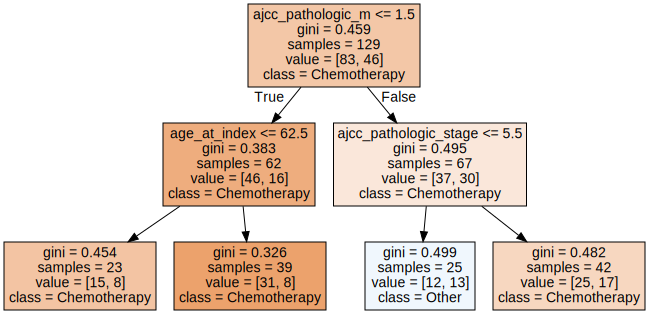

In [53]:
# 6. Visualize graph with graphviz library
dot_data = tree.export_graphviz(dt_clf, out_file=None, feature_names= X_encoded.columns, class_names=['Chemotherapy', 'Other'], filled=True)
dt_graph = graphviz.Source(dot_data, format="png")
dt_graph

In [54]:
# 6. Export DT as an image
dt_graph.format = "png"
dt_graph.render("xai_pancreas_DT_medium")

'xai_pancreas_DT_medium.png'

# Permutation Importance

Permutation Importance is an algorithm that computes importance scores
for each of the feature variables of a dataset. The importance measures are determined by computing the sensitivity of a model to random permutations of feature values.

It measures the importance of a feature by calculating the increase in the model’s prediction error after permuting the feature.

In [22]:
# 1. Install required package
!pip install eli5
import eli5
from eli5.sklearn import PermutationImportance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.2/216.2 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107719 sha256=34b82d7670608cefcae45227766bacff811fc276346067da4a1fd23292309a59
  Stored in directory: /root/.cache/pip/wheels/b8/58/ef/2cf4c306898c2338d51540e0922c8e0d6028e07007085c0004
Successfully built eli5


In [23]:
# 2. Get permutation importance data and show weights
dt_perm = PermutationImportance(dt_clf, random_state=42).fit(X_test, y_test)
eli5.show_weights(dt_perm, feature_names = X_encoded.columns.tolist())

In [24]:
# 3. Patient 3 data
eli5.show_prediction(dt_clf, X_train.iloc[2])

In [25]:
# 4. Patient 4 data
eli5.show_prediction(dt_clf, X_train.iloc[3])

# Exaplainability with SHAP

In [26]:
!pip install shap
import shap


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 6.0 MB/s eta 0:00:00


In [27]:
# Explain the model's predictions using SHAP
explainerShap = shap.TreeExplainer(dt_clf)

# Compute shap_values for X_test
shap_values = explainerShap.shap_values(X_test)

**Pacient 3**
Get the data from patient 3

In [28]:
paciente3 = X_encoded.loc[[2]]
paciente3

age_at_index  ajcc_pathologic_m  ajcc_pathologic_n  ajcc_pathologic_stage  \
2            58                  1                  0                      8   

   ajcc_pathologic_t  treatment_type_Pharmaceutical Therapy, NOS  \
2                  3                                           1   

   treatment_type_Radiation Therapy, NOS  ethnicity_hispanic or latino  \
2                                      0                             0   

   ethnicity_not hispanic or latino  ethnicity_not reported  ...  \
2                                 1                       0  ...   

   primary_diagnosis_Neuroendocrine carcinoma, NOS  prior_malignancy_no  \
2                                                0                    1   

   prior_malignancy_yes  prior_treatment_No  prior_treatment_Yes  \
2                     0                   1                    0   

   tissue_or_organ_of_origin_Body of pancreas  \
2                                           0   

   tissue_or_organ_of_origin_Head of pancreas  \
2                                           0   

   tissue_or_organ_of_origin_Overlapping lesion of pancreas  \
2                                                  0          

   tissue_or_organ_of_origin_Pancreas, NOS  \
2                                        0   

   tissue_or_organ_of_origin_Tail of pancreas  
2                                           1  

[1 rows x 31 columns]

In [29]:
y[2]

'Other'

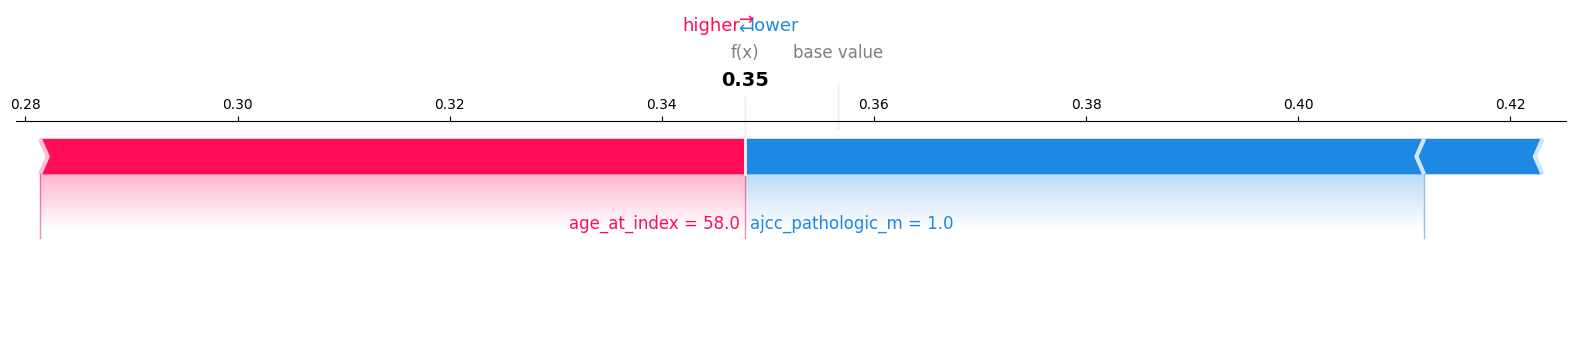

In [30]:
shap.initjs()
paciente3_shap_values = explainerShap.shap_values(paciente3)

shap.force_plot(explainerShap.expected_value[1], paciente3_shap_values[1], paciente3, matplotlib = True, show=False)

In [31]:
#plt.savefig("shap_paciente3.png")
plt.close()

Paciente 4

In [32]:
paciente4 = X_encoded.loc[[3]]
paciente4

age_at_index  ajcc_pathologic_m  ajcc_pathologic_n  ajcc_pathologic_stage  \
3            66                  0                  0                      5   

   ajcc_pathologic_t  treatment_type_Pharmaceutical Therapy, NOS  \
3                  3                                           1   

   treatment_type_Radiation Therapy, NOS  ethnicity_hispanic or latino  \
3                                      0                             0   

   ethnicity_not hispanic or latino  ethnicity_not reported  ...  \
3                                 1                       0  ...   

   primary_diagnosis_Neuroendocrine carcinoma, NOS  prior_malignancy_no  \
3                                                0                    1   

   prior_malignancy_yes  prior_treatment_No  prior_treatment_Yes  \
3                     0                   1                    0   

   tissue_or_organ_of_origin_Body of pancreas  \
3                                           0   

   tissue_or_organ_of_origin_Head of pancreas  \
3                                           0   

   tissue_or_organ_of_origin_Overlapping lesion of pancreas  \
3                                                  0          

   tissue_or_organ_of_origin_Pancreas, NOS  \
3                                        1   

   tissue_or_organ_of_origin_Tail of pancreas  
3                                           0  

[1 rows x 31 columns]

In [33]:
y[3]

'Chemotherapy'

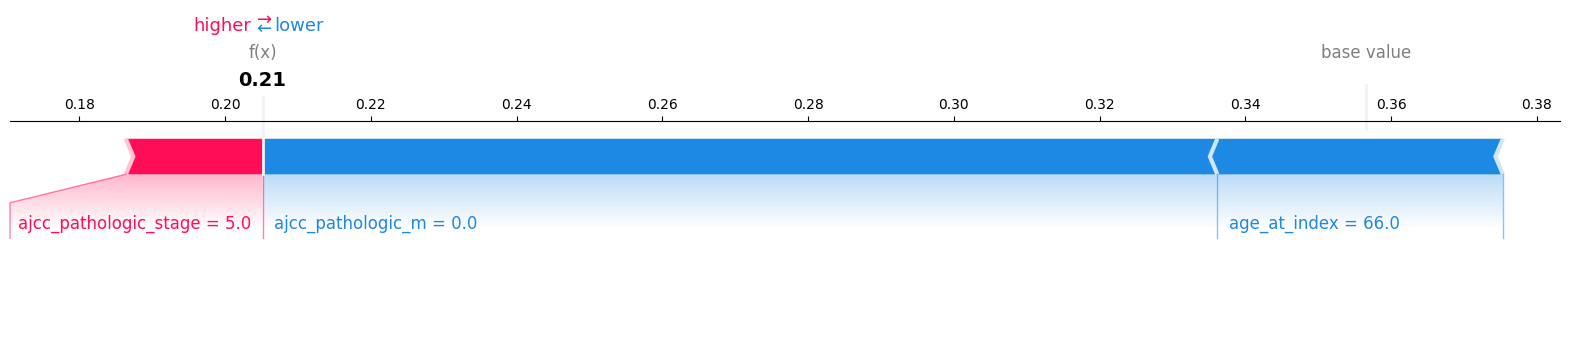

In [34]:
paciente4_shap_values = explainerShap.shap_values(paciente4)

shap.force_plot(explainerShap.expected_value[1], paciente4_shap_values[1], paciente4, matplotlib = True, show=False)

Feature values in pink cause to increase the prediction. Size of the bar shows the magnitude of the feature's effect.

Feature values in blue causse to decrease the prediction. Sum of all feature SHAP values explain why model prediction was different from the baseline.

In [35]:
#plt.savefig("shap_paciente4.png")
plt.close()

Summary plot will give us the variable importance plot. Features with high predicting power are shown at the top and the ones with low predicting powers are shown at the bottom.

We could see the contribution of each data into the prediction probability. The redder the colour, the higher the value and vice versa. Also, when the value is on the positive side, it contributes to the class 0 prediction result probability and vice versa.

Variable Importance Plot - Global Interpretation


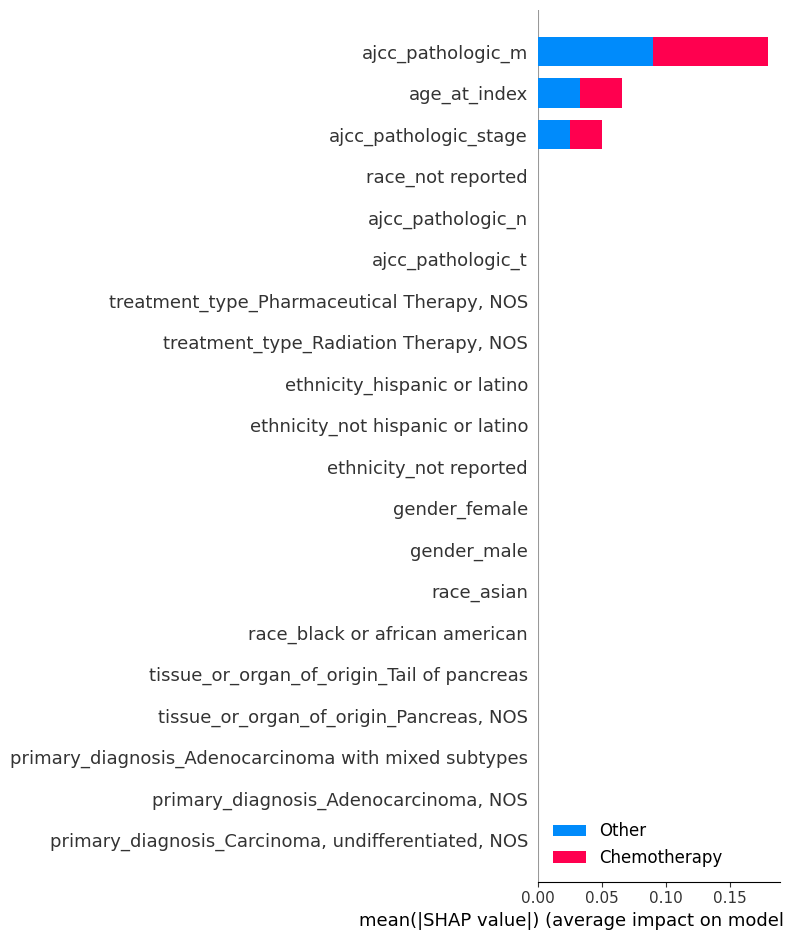

In [36]:
print("Variable Importance Plot - Global Interpretation")
shap.summary_plot(shap_values, X_test, plot_type='bar', class_names=['Chemotherapy','Other'])

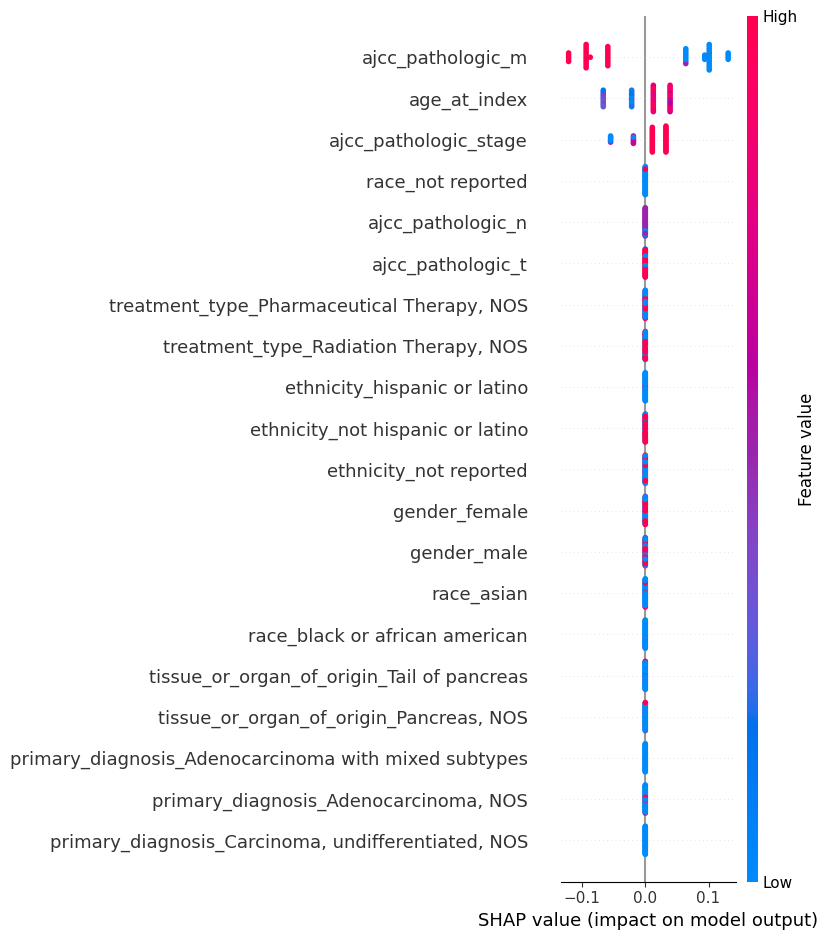

In [37]:
# Summary plot in an individual sample
shap.summary_plot(shap_values[0], X_test)

The **partial dependence plot** is a global method: The method considers all instances and gives a statement about the global relationship of a feature with the predicted outcome.

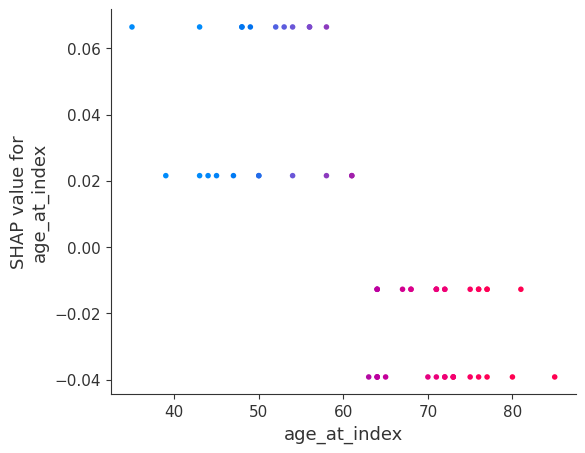

In [38]:
shap.dependence_plot('age_at_index', shap_values[1], X_test, interaction_index='age_at_index')

A continuación incluimos un gráfico de decisión:

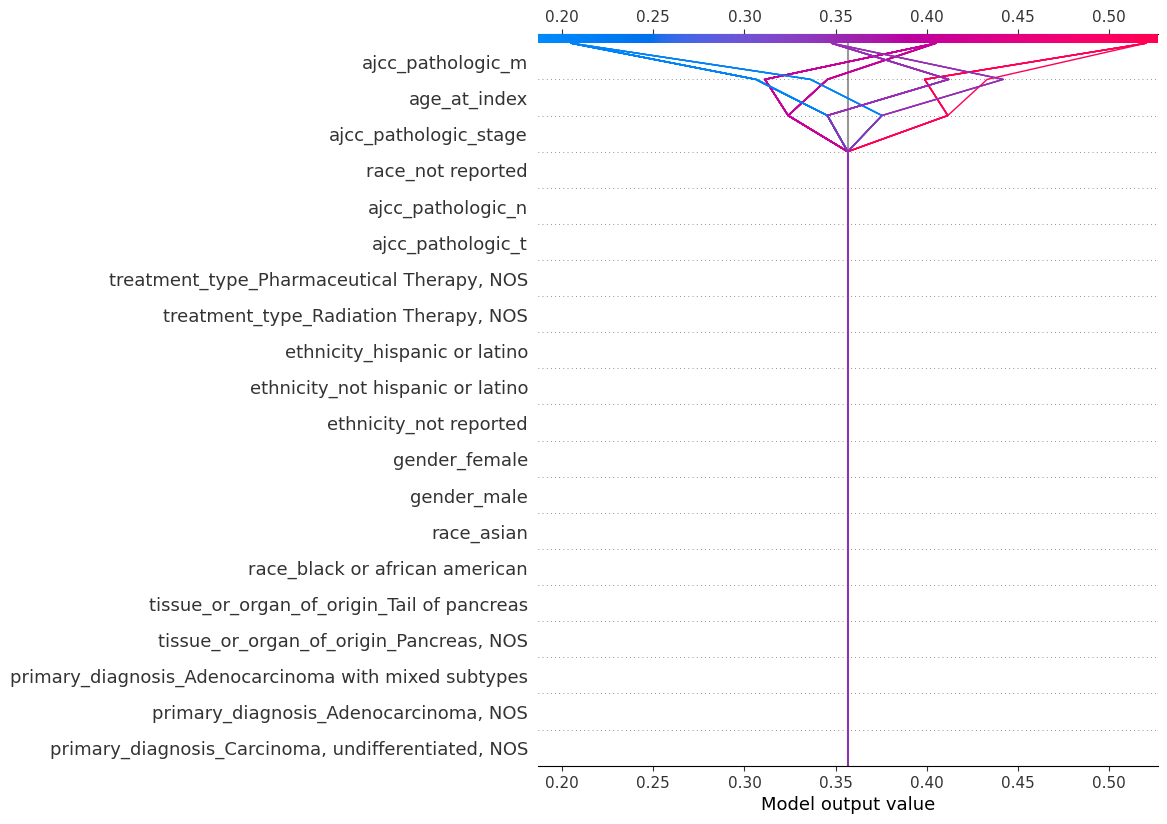

In [39]:
i=1
shap.decision_plot(explainerShap.expected_value[i], shap_values[i], feature_names = list(X_encoded.columns))

Y finalmente un gráfico de fuerzas:

In [40]:
shap.initjs()
i = 1
shap.force_plot(explainerShap.expected_value[i], shap_values[i], feature_names = list(X_encoded.columns))

# Explainability with LIME

LIME (Local Interpretable Model-Agnostic Explanations) is a method for explaining the predictions of any classifier and regressor (model agnostic).

In [41]:
# Install SHAP (SHapley Additive exPlanations).
!pip install lime

# Import required libraries
from lime.lime_tabular import LimeTabularExplainer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=42d0b256a2d8bb16a6da17d930c69df70653a9e1033c0119847f9a8c6cb3896e
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [42]:
# XAI with LIME (Local Interpretable Model-agnostic Explanations)
explainerLime = LimeTabularExplainer(X_encoded.values, feature_names=X_encoded.columns, class_names = ['Chemotherapy', 'Other'], discretize_continuous=True)
#explainer2 = LimeTabularExplainer(X_encoded.values[:,:], feature_names = X_encoded.columns,class_names=['Chemotherapy','Other'], discretizer='decile',kernel_width=5,discretize_continuous=True,verbose=True)

# Patient 3 LIME explanation
expPatient3 = explainerLime.explain_instance(X_encoded.values[2], dt_clf.predict_proba, num_features=10, top_labels=5)
#exp2 = explainer2.explain_instance(X_encoded.iloc[1,:],rf_clf.predict_proba)

expPatient3.show_in_notebook(show_all=True)
expPatient3.as_pyplot_figure()
plt.close()


X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


In [43]:
# Patient 4 LIME explanation
expPatient4 = explainerLime.explain_instance(X_encoded.values[3], dt_clf.predict_proba, num_features=10, top_labels=3)
expPatient4.show_in_notebook(show_all=True)
expPatient4.as_pyplot_figure()
plt.close()

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


# Partial Dependence Plot (PDP)
Partial Dependence (PD) is a global and model-agnostic XAI method. PDP shows the marginal effect or contribution of individual feature(s) to the predictive value of your black box model.

Caveat: It is assumed that the feature(s) for which the partial dependence is computed are not correlated with other features.

REF: https://towardsdatascience.com/partial-dependence-plots-with-scikit-learn-966ace4864fc

In [44]:
from sklearn.inspection import PartialDependenceDisplay
import seaborn as sns
sns.set(style='darkgrid', context='talk', palette='Set2')

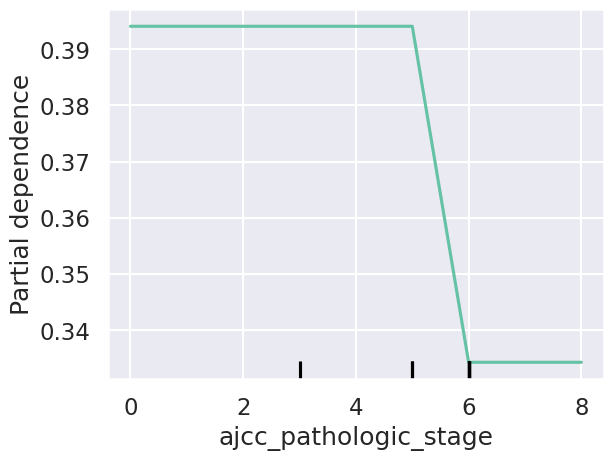

In [45]:
disp1 = PartialDependenceDisplay.from_estimator(dt_clf, X_train, ['ajcc_pathologic_stage'])
plt.show()
plt.close()

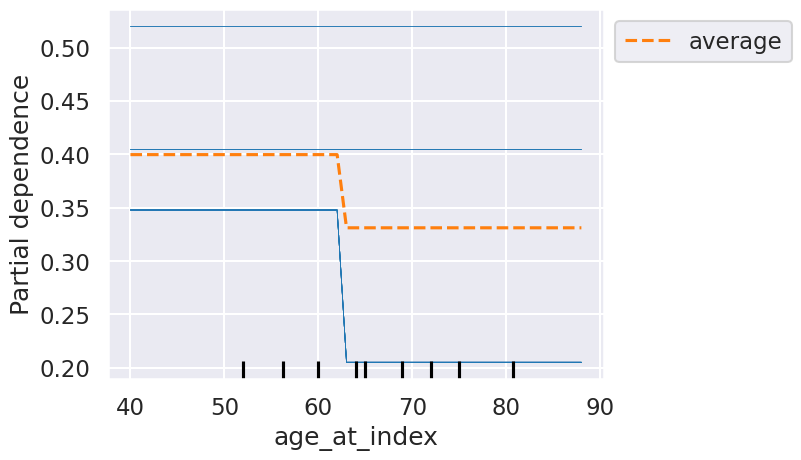

In [46]:
n = 50
PartialDependenceDisplay.from_estimator(
    dt_clf, X_train, ['age_at_index'], kind="both", n_jobs=3, subsample=n
)
plt.legend(bbox_to_anchor=(1,1));
plt.show()
plt.close()

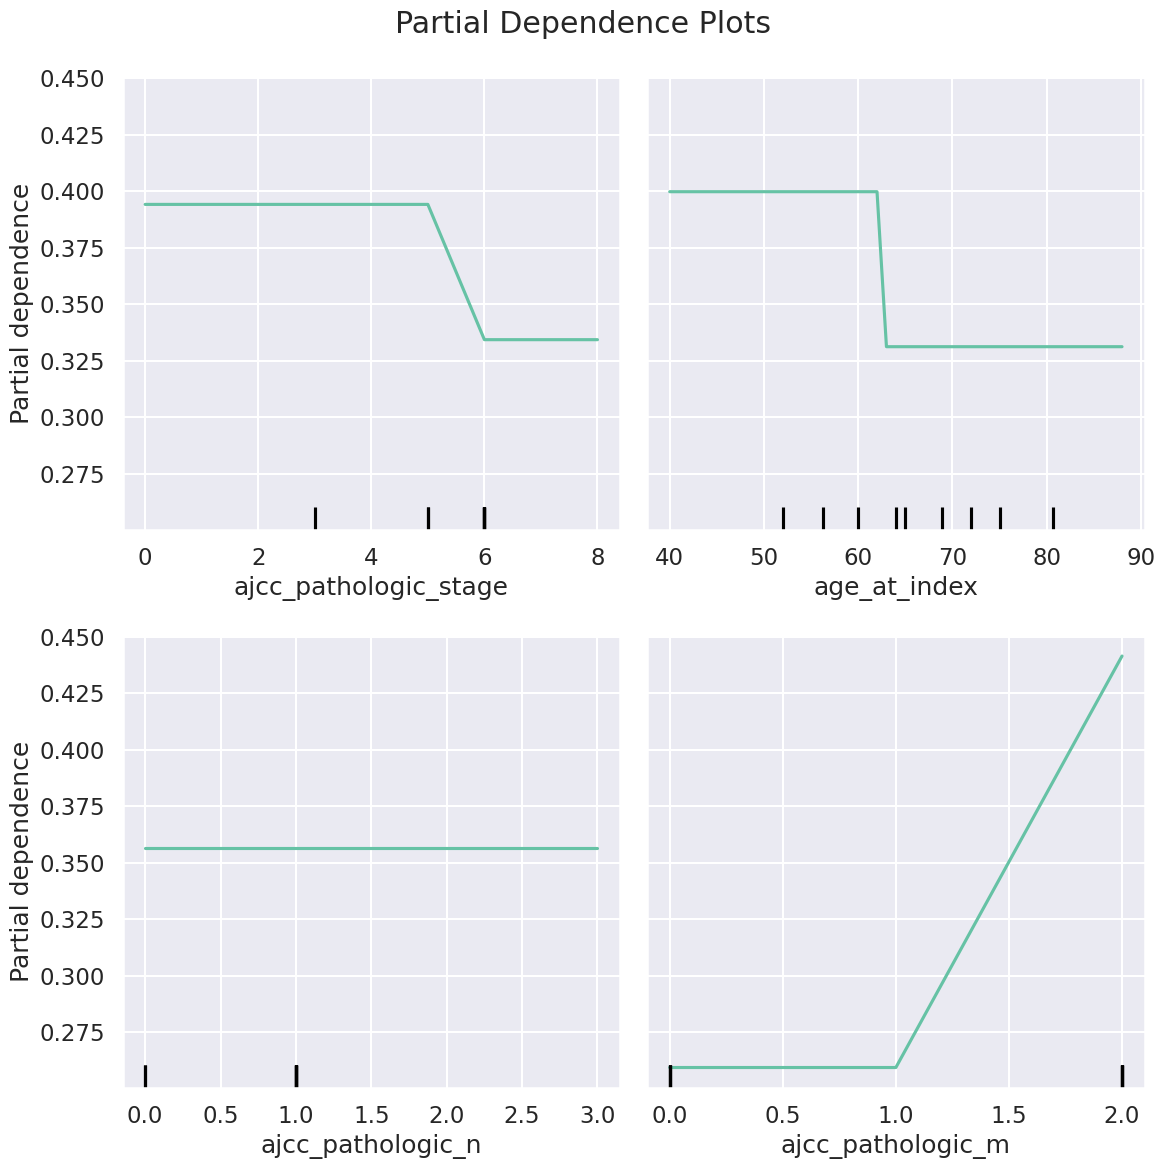

In [47]:
n_cols = 2
n_rows = 2
fig, ax = plt.subplots(n_rows, n_cols, figsize=(12, 12))
PartialDependenceDisplay.from_estimator(dt_clf, X_train,
  ['ajcc_pathologic_stage', 'age_at_index', 'ajcc_pathologic_n', 'ajcc_pathologic_m'], ax=ax)
fig.suptitle('Partial Dependence Plots')
fig.tight_layout();
plt.show()
plt.close()